# Self-Driving Car Engineer Nanodegree

## Deep Learning

## Project: Build a Traffic Sign Recognition Classifier

In this notebook, a template is provided for you to implement your functionality in stages which is required to successfully complete this project. If additional code is required that cannot be included in the notebook, be sure that the Python code is successfully imported and included in your submission, if necessary. Sections that begin with **'Implementation'** in the header indicate where you should begin your implementation for your project. Note that some sections of implementation are optional, and will be marked with **'Optional'** in the header.

In addition to implementing code, there will be questions that you must answer which relate to the project and your implementation. Each section where you will answer a question is preceded by a **'Question'** header. Carefully read each question and provide thorough answers in the following text boxes that begin with **'Answer:'**. Your project submission will be evaluated based on your answers to each of the questions and the implementation you provide.

>**Note:** Code and Markdown cells can be executed using the **Shift + Enter** keyboard shortcut. In addition, Markdown cells can be edited by typically double-clicking the cell to enter edit mode.

---

## Step 1: Dataset Exploration

Visualize the German Traffic Signs Dataset. This is open ended, some suggestions include: plotting traffic signs images, plotting the count of each sign, etc. Be creative!


The pickled data is a dictionary with 4 key/value pairs:

- features -> the images pixel values, (width, height, channels)
- labels -> the label of the traffic sign
- sizes -> the original width and height of the image, (width, height)
- coords -> coordinates of a bounding box around the sign in the image, (x1, y1, x2, y2). Based the original image (not the resized version).

In [1]:
# Load pickled data
import pickle

# TODO: fill this in based on where you saved the training and testing data
training_file = "lab 2 data/train.p"
testing_file = "lab 2 data/test.p"

with open(training_file, mode='rb') as f:
    train = pickle.load(f)
with open(testing_file, mode='rb') as f:
    test = pickle.load(f)
    
X_train, y_train = train['features'], train['labels']
X_test, y_test = test['features'], test['labels']

In [2]:
### To start off let's do a basic data summary.
import numpy as np

# TODO: number of training examples
n_train = len(X_train)

# TODO: number of testing examples
n_test = len(X_test)

# TODO: what's the shape of an image?
image_shape = X_train[1].shape

# TODO: how many classes are in the dataset
n_classes = len(np.unique(y_train))

print("Number of training examples =", n_train)
print("Number of testing examples =", n_test)
print("Image data shape =", image_shape)
print("Number of classes =", n_classes)

Number of training examples = 39209
Number of testing examples = 12630
Image data shape = (32, 32, 3)
Number of classes = 43


In [5]:
### Data exploration visualization goes here.
### Feel free to use as many code cells as needed.

### Seeing the Data
Let's see what sorts of images we'll be training a classifier on!

In [3]:
from PIL import Image
import matplotlib.pyplot as plt
%matplotlib inline

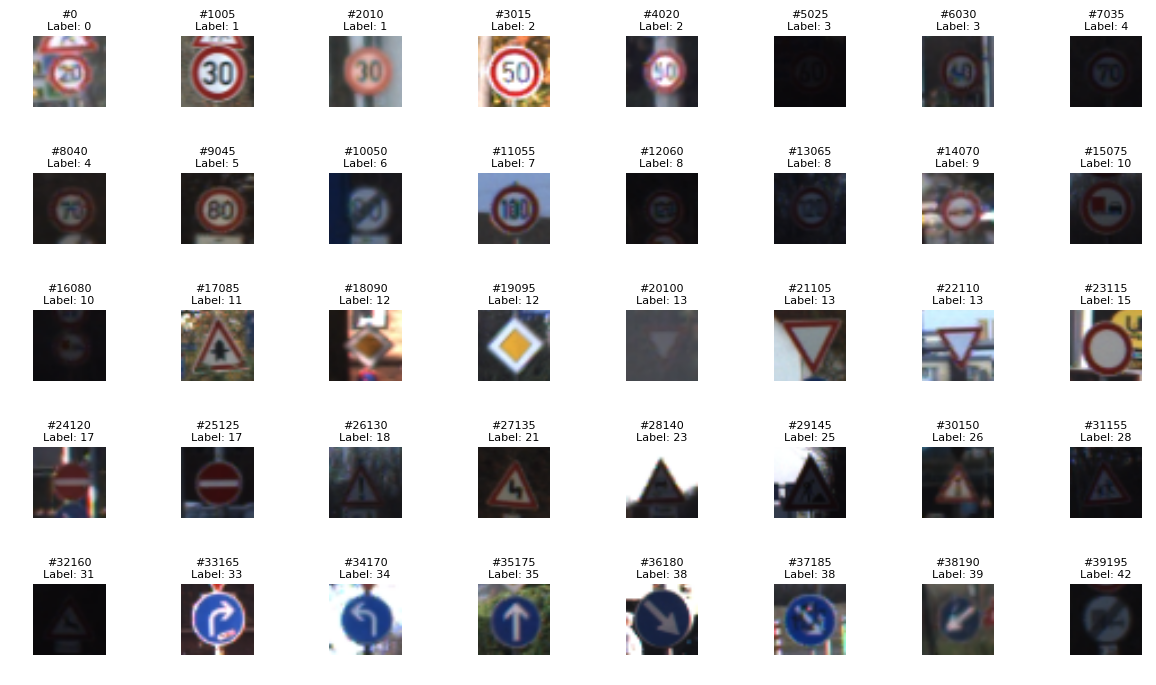

In [7]:
fig = plt.figure(figsize=(12, 7))
for i, n in enumerate(range(0,39209,1005)):
    fig.add_subplot(5, 8, i+1)
    img = Image.fromarray(X_train[n], 'RGB')
    plt.axis("off")
    plt.title("#" + str(n) + "\nLabel: " + str(y_train[n]), fontsize=8)
    plt.imshow(img)
plt.tight_layout()
plt.show()

Pretty cool!  
I wonder how these labels are distributed

### Label Distribution

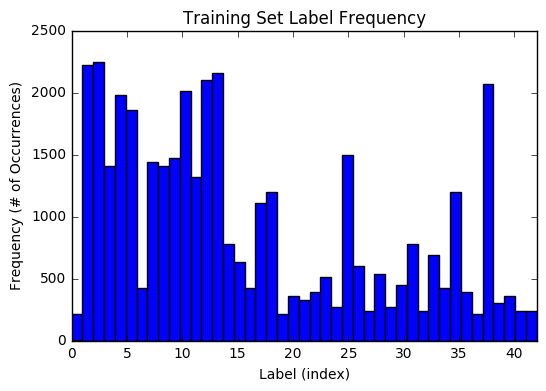

In [8]:
n, bins, patches = plt.hist(y_train, bins=43)
plt.axis([0,42,0,2500])
plt.title("Training Set Label Frequency")
plt.ylabel("Frequency (# of Occurrences)")
plt.xlabel("Label (index)")

Some of the signs in the dataset appear way more frequently than do some of the other signs.

In [9]:
np.argmax(n), np.argmin(n)

(2, 0)

From the above, we can see that the **most** common label is `2`.  
Additionally, the **least** common label is `0`.

In [10]:
max(n) / min(n)

10.714285714285714

More specifically, there are almost 11 times **more** instances of label `2` than there are of label `0`.

Thus, this dataset is super [unbalanced](https://carnd-udacity.atlassian.net/wiki/questions/10322627/project-2-unbalanced-data-generating-additional-data-by-jittering-the-original-image).

### The "Average" Image
I wonder if there's anything we can notice about the average image

In [33]:
avg_img = np.average(X_train, axis=0)

In [67]:
avg_img = np.array(np.round(avg_img), dtype=np.uint8)

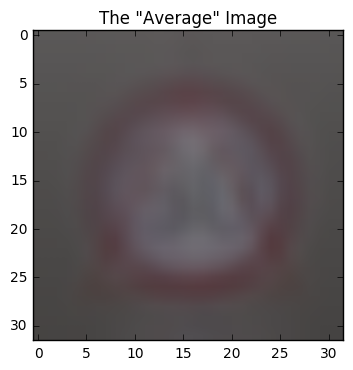

In [68]:
fig1 = plt.figure()
img = Image.fromarray(avg_img, 'RGB')
img.show()
plt.title("The \"Average\" Image")
plt.imshow(img)

Well that's nifty!  I'm not sure how useful it is, but it does convey a sense of the centrality of the signs in the image, and that, in general, these images present some kind of white sign, bordered by red, with digits in the middle.
Let's split this average image into its constituent channels to see if there's anything we can notice there.

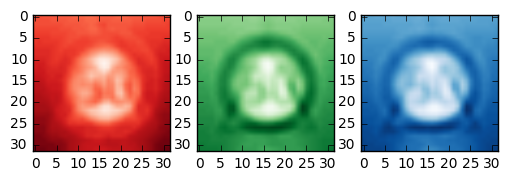

In [89]:
red, green, blue = img.split()
colors = ("Reds_r", "Greens_r", "Blues_r")
split = (red, green, blue)
fig = plt.figure()
for i in range(3):
    fig.add_subplot(1, 3, i+1)
    plt.imshow(split[i])
    plt.set_cmap(colors[i])

(Note, the channels in the above images have been normalized, as is the default behavior for [`plt.imshow()`](http://matplotlib.org/api/pyplot_api.html#matplotlib.pyplot.imshow))

As shown above, in the **Red** channel, it would appear that, on average, our signs read **90**, while they appear to read **50** in the other channels.

Additionally, in the **Blue** channel and especially in the **Green** channel, the bordering of the intense ("white") foreground is especially prominent.

I would suspect that a Neural Net could make use of the information contained in each of these channels in different ways:  
For instance, to detect the boundaries of the signs, it would appear that the Neural Net could rely heavily on the **Green** and **Blue** channels.  
Or, to be able to read the test on the sign, it may be advantageous for the Neural Net to focus on the information contained in the **Red** channel.  
The Neural Net may even be able to build a consensus of what it thinks it's detecting by querying multiple channels, for example about whether it's seeing a **90** or a **50**.

### Sign Location Heatmap
All of the images we're working with in the pickled data have been resized to `(32, 32)` and more or less centered, but `train["coords"]` retains the location of the signs in the original image.

For funsies, let's see where the corners generally are.

In [14]:
allPoints = []
for i, box in enumerate(train['coords']):
    allPoints.append((box[0] / train['sizes'][i][0], box[1] / train['sizes'][i][1]))
    allPoints.append((box[0] / train['sizes'][i][0], box[3] / train['sizes'][i][1]))
    allPoints.append((box[2] / train['sizes'][i][0], box[1] / train['sizes'][i][1]))
    allPoints.append((box[2] / train['sizes'][i][0], box[3] / train['sizes'][i][1]))

In [15]:
xs,ys = zip(*allPoints)

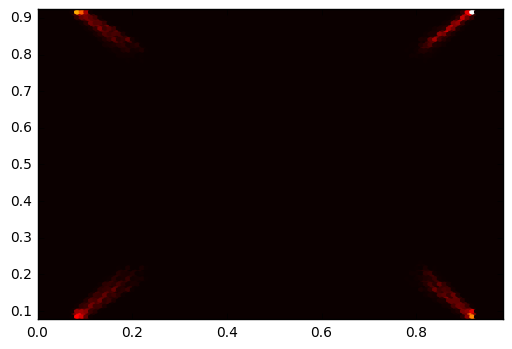

In [16]:
plt.hexbin(xs,ys,cmap="hot")
plt.show()

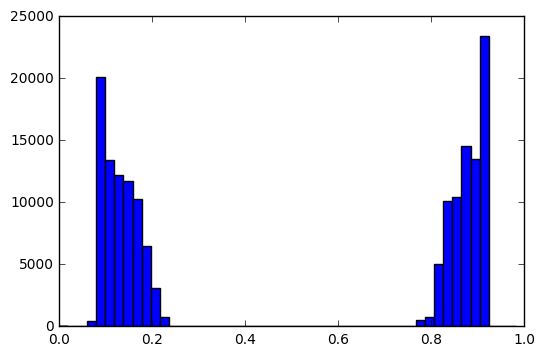

In [17]:
plt.hist(xs, bins=50)
plt.show()

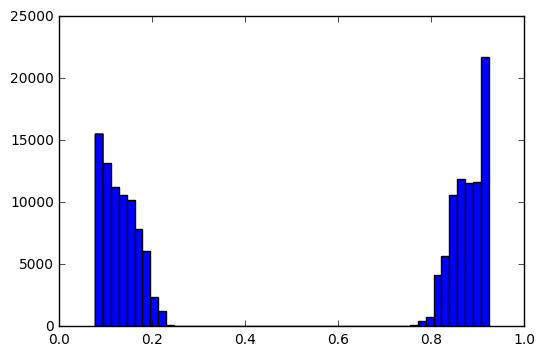

In [18]:
plt.hist(ys, bins=50)
plt.show()

<img style="float: left; margin-left: 60px" src="https://memecrunch.com/meme/29ZEI/i-don-t-know-what-i-expected/image.jpg?w=462&c=1">

Onward!

----

## Step 2: Design and Test a Model Architecture

Design and implement a deep learning model that learns to recognize traffic signs. Train and test your model on the [German Traffic Sign Dataset](http://benchmark.ini.rub.de/?section=gtsrb&subsection=dataset).

There are various aspects to consider when thinking about this problem:

- Your model can be derived from a deep feedforward net or a deep convolutional network.
- Play around preprocessing techniques (normalization, rgb to grayscale, etc)
- Number of examples per label (some have more than others).
- Generate fake data.

Here is an example of a [published baseline model on this problem](http://yann.lecun.com/exdb/publis/pdf/sermanet-ijcnn-11.pdf). It's not required to be familiar with the approach used in the paper but, it's good practice to try to read papers like these.

### Implementation

Use the code cell (or multiple code cells, if necessary) to implement the first step of your project. Once you have completed your implementation and are satisfied with the results, be sure to thoroughly answer the questions that follow.

#### RGB to Grayscale

In [4]:
def toGrayscale(img_array):
    '''
    img_array: a numpy array representing a 3-channel image
    returns a grayscale Image
    '''
    img = Image.fromarray(img_array, 'RGB')
    gray = img.convert('L')
    return gray

In [5]:
import random as rand

15268


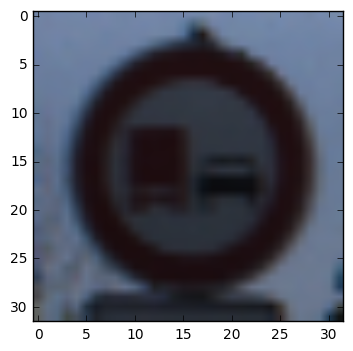

In [73]:
#choice = rand.randint(0,39209)
choice = 15268
print(choice)
ex = X_train[choice]
plt.imshow(ex)

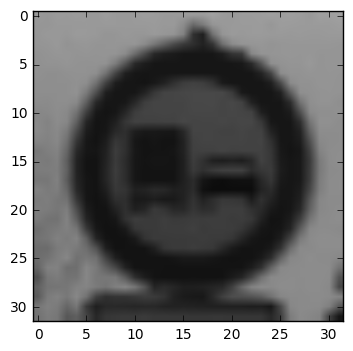

In [81]:
gray = toGrayscale(ex)
plt.imshow(gray, cmap="Greys_r", vmin=0, vmax=255)

#### Normalization

In [6]:
def normalize(gray_img_array):
    '''
    gray_img_array: a numpy array representing a 1-channel grayscale image
    returns a numpy array which has been linearly normalized
    
    https://en.wikipedia.org/wiki/Normalization_(image_processing)
    '''
    iMax = np.max(gray_img_array)
    iMin = np.min(gray_img_array)
    
    newMax = 255
    newMin = 0
    
    norm = lambda elem: (elem - iMin) * (newMax - newMin) / (iMax - iMin) + newMin
    elem_norm = np.vectorize(norm)
    
    return elem_norm(gray_img_array)

def imstat(img):
    print("Max value is: " + str(np.max(np.array(img))))
    print("Min value is: " + str(np.min(np.array(img))))

In [84]:
normalized = normalize(np.array(gray))

Intensities for gray:
Max value is: 137
Min value is: 11

Intensities for normalized:
Max value is: 255.0
Min value is: 0.0


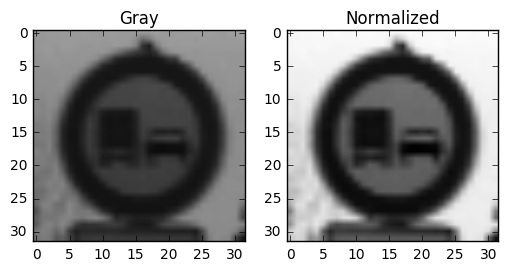

In [85]:
fig = plt.figure()
fig.add_subplot(1, 2, 1)
#gray.show()
plt.title("Gray")
plt.imshow(gray, norm=None, cmap="Greys_r", vmin=0, vmax=255)

fig.add_subplot(1, 2, 2)
#Image.fromarray(normalized).show()
plt.title("Normalized")
plt.imshow(normalized, norm=None, cmap="Greys_r", vmin=0, vmax=255)

print("Intensities for gray:")
imstat(gray)
print("\nIntensities for normalized:")
imstat(normalized)

In [7]:
def preprocess(img_array):
    return normalize(np.array(toGrayscale(img_array)))

### Question 1 

_Describe the techniques used to preprocess the data._

**Preliminary Thoughts**

In [ ]:
### Generate data additional (if you want to!)
### and split the data into training/validation/testing sets here.
### Feel free to use as many code cells as needed.

In [ ]:
### (1) Dataset is unbalanced; generate additional data from under-populated classes to compensate (even with TF?)
### (2) changing to grayscale and normalizing is mentioned as a way of preprocessing
### (3) 99.8% achieved by inception models
### (4) we discussed building a TF model, and also that's what you're looking to do with ML, so maybe do that
### (5) Pre-training with an auto-encoder is mentioned, but not explained, and seems complicated

**Answer:**

To preprocess the data, images will be converted into grayscale, and then normalized to make full use of the intensity spectrum (0-255).

The helper functions to accomplish these preprocessing tasks are defined and demonstrated above.

This is largely because [Sermanet and LeCun](http://yann.lecun.com/exdb/publis/pdf/sermanet-ijcnn-11.pdf) report better performance after having converted their images from full 3-channel color into grayscale, and then normalizing.

### Question 2

_Describe how you set up the training, validation and testing data for your model. If you generated additional data, why?_

**Preliminary Thoughts**

In [25]:
### Define your architecture here.
### Feel free to use as many code cells as needed.

### (1) will need some convolutions, maybe follow the TF advanced tutorial?
### https://www.tensorflow.org/versions/r0.11/tutorials/deep_cnn/index.html
### Actually, the above is not very detailed, except for the raw source code

**Answer:**

Note, from above, that the training and testing data has already been split
```
X_train, y_train = train['features'], train['labels']
X_test, y_test = test['features'], test['labels']
```
The possibility exists to generate additional data in order to [balance under-populated classes](https://medium.com/@vivek.yadav/dealing-with-unbalanced-data-generating-additional-data-by-jittering-the-original-image-7497fe2119c3#.x727w2lda), and indeed the rationale for eliminating a model's bias towards common data is cogent.  
However, such preprocessing techniques are contrary to the spirit of Machine Learning, whereby we would like to be able to feed data into as black of a box as possible and retrieve meaningful results.  Certainly this wish for a free lunch has its limitations, but it's not the case that every lunch needs to cost $20 USD.  
Not unrelatedly, the process itself of generating additional data can introduce insidious bias into the dataset if not done skillfully (which would be the case were I to try to generate additional data through jitter, since that is a process with which I am largely unfamiliar).  

While [methods](https://carnd-udacity.atlassian.net/wiki/questions/10322627/project-2-unbalanced-data-generating-additional-data-by-jittering-the-original-image) exist for generating additional jittered data, in the interest of not merely stitching together other people's work to create my pipeline, I will forego the step of generating additional data to balance an admittedly-unbalanced dataset.

### Question 3

_What does your final architecture look like? (Type of model, layers, sizes, connectivity, etc.)  For reference on how to build a deep neural network using TensorFlow, see [Deep Neural Network in TensorFlow
](https://classroom.udacity.com/nanodegrees/nd013/parts/fbf77062-5703-404e-b60c-95b78b2f3f9e/modules/6df7ae49-c61c-4bb2-a23e-6527e69209ec/lessons/b516a270-8600-4f93-a0a3-20dfeabe5da6/concepts/83a3a2a2-a9bd-4b7b-95b0-eb924ab14432) from the classroom._


In [ ]:
### Train your model here.
### Feel free to use as many code cells as needed.

### (1) Revisit the beginner TF tutorial for how to train a tensor with forward and backprop?

Note that we'll want to define a tensor for solving this problem, as that library provides a great deal of standardization and deep learning primitives

In [8]:
import tensorflow as tf

In [9]:
# Define the TensorFlow placeholder for each individual GTSRB image
tf_x = tf.placeholder("float", [None, 32, 32, 1])

In [10]:
# Define the TensorFlow placeholder for the difference number of classes in GTSRB (43)
tf_y = tf.placeholder("float", [None, n_classes])

In [11]:
n_input = 32 * 32

In [12]:
tf_x_flat = tf.reshape(tf_x, [-1, n_input])

Now let's define some parameters

In [13]:
n_hidden_layer = 256

weights = {
    'hidden_layer': tf.Variable(tf.random_normal([n_input, n_hidden_layer])),
    'out': tf.Variable(tf.random_normal([n_hidden_layer, n_classes]))
}
biases = {
    'hidden_layer': tf.Variable(tf.random_normal([n_hidden_layer])),
    'out': tf.Variable(tf.random_normal([n_classes]))
}

In [14]:
learning_rate = 0.001
training_epochs = 15
batch_size = 100
display_step = 1

Next, let's define what our hidden layer will look like

In [15]:
# Hidden layer with RELU activation
layer_1 = tf.add(tf.matmul(tf_x_flat, weights['hidden_layer']), biases['hidden_layer'])
layer_1 = tf.nn.relu(layer_1)
# Output layer with linear activation
logits = tf.matmul(layer_1, weights['out']) + biases['out']

Now, let's define our cost function

In [16]:
# Define loss and optimizer
cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits, tf_y))
optimizer = tf.train.GradientDescentOptimizer(learning_rate=learning_rate).minimize(cost)

Now, let's initialize the session and run the model

In [52]:
def reshapeAndPreprocess(x):
    '''
    Given a numpy array of inputs, first preprocess the inputs
    (convert to grayscale and normalize), then reshape the inputs.
    Returns a numpy array of preprocessed, reshaped inputs.
    '''
    for i, a in enumerate(x):
        x[i] = preprocess(a)
    return np.reshape(x, (-1, 32, 32, 1))

In [53]:
x_res_pre = reshapeAndPreprocess(X_train)

ValueError: could not broadcast input array from shape (32,32) into shape (32,32,3)

In [51]:
x_res_pre.shape

(117627, 32, 32, 1)

In [17]:
X_res = np.reshape(X_train,(-1,32,32,1))

In [38]:
def oneHot(y):
    y_hot = np.zeros((y.shape[0], 43))
    for i, e in enumerate(y):
        y_hot[i][e] = True
    return y_hot

In [39]:
y_hot = oneHot(y_train)

In [40]:
def getBatches(batch_size):
    batch_x = []
    batch_y = []
    chosen = []
    while len(chosen) < batch_size:
        i = rand.randint(0, 39208)
        if i not in chosen:
            chosen.append(i)
            batch_x.append(X_res[i])
            batch_y.append(y_hot[i])
    return np.array(batch_x), np.array(batch_y)

In [44]:
X_train.shape, X_res.shape

((39209, 32, 32, 3), (117627, 32, 32, 1))

In [43]:
X_test.shape, X_test_res.shape, y_test_hot.shape

((12630, 32, 32, 3), (37890, 32, 32, 1), (12630, 43))

In [41]:
# Initializing the variables
init = tf.initialize_all_variables()


# Launch the graph
with tf.Session() as sess:
    sess.run(init)
    # Training cycle
    for epoch in range(training_epochs):
        total_batch = int(len(X_train)/batch_size)
        # Loop over all batches
        for i in range(total_batch):
            batch_x, batch_y = getBatches(batch_size)
            # Run optimization op (backprop) and cost op (to get loss value)
            sess.run(optimizer, feed_dict={tf_x: batch_x, tf_y: batch_y})
        if epoch % display_step == 0:
            c = sess.run(cost, feed_dict={tf_x: batch_x, tf_y: batch_y})
            print("Epoch:", '%04d' % (epoch+ 1 ), "cost=", "{:.9f}".format(c))   
    print("Optimization finished!")

    # Now let's test our model and calculate the accuracy.

    correct_prediction = tf.equal(tf.argmax(logits, 1), tf.argmax(tf_y, 1))

    X_test_res = np.reshape(X_test,(-1,32,32,1))
    y_test_hot = oneHot(y_test)

    accuracy = tf.reduce_mean(tf.cast(correct_prediction, "float"))
    print("Accuracy:", accuracy.eval({tf_x: X_test_res, tf_y: y_test_hot}))

Epoch: 0001 cost= 33.529373169
Epoch: 0002 cost= 4.251343250
Epoch: 0003 cost= 4.242825031
Epoch: 0004 cost= 4.273508072
Epoch: 0005 cost= 4.212894440
Epoch: 0006 cost= 4.104234695
Epoch: 0007 cost= 6.906957626
Epoch: 0008 cost= 4.174996376
Epoch: 0009 cost= 3.939894199
Epoch: 0010 cost= 4.088627338
Epoch: 0011 cost= 8.618966103
Epoch: 0012 cost= 4.047558308
Epoch: 0013 cost= 4.081579208
Epoch: 0014 cost= 4.147669792
Epoch: 0015 cost= 4.022911072
Optimization finished!


InvalidArgumentError: Incompatible shapes: [37890] vs. [12630]
	 [[Node: Equal_3 = Equal[T=DT_INT64, _device="/job:localhost/replica:0/task:0/cpu:0"](ArgMax_7, ArgMax_8)]]

Caused by op 'Equal_3', defined at:
  File "/usr/lib/python3.5/runpy.py", line 184, in _run_module_as_main
    "__main__", mod_spec)
  File "/usr/lib/python3.5/runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "/usr/lib/python3.5/site-packages/ipykernel/__main__.py", line 3, in <module>
    app.launch_new_instance()
  File "/usr/lib/python3.5/site-packages/traitlets/config/application.py", line 658, in launch_instance
    app.start()
  File "/usr/lib/python3.5/site-packages/ipykernel/kernelapp.py", line 474, in start
    ioloop.IOLoop.instance().start()
  File "/usr/lib/python3.5/site-packages/zmq/eventloop/ioloop.py", line 177, in start
    super(ZMQIOLoop, self).start()
  File "/usr/lib/python3.5/site-packages/tornado/ioloop.py", line 887, in start
    handler_func(fd_obj, events)
  File "/usr/lib/python3.5/site-packages/tornado/stack_context.py", line 275, in null_wrapper
    return fn(*args, **kwargs)
  File "/usr/lib/python3.5/site-packages/zmq/eventloop/zmqstream.py", line 440, in _handle_events
    self._handle_recv()
  File "/usr/lib/python3.5/site-packages/zmq/eventloop/zmqstream.py", line 472, in _handle_recv
    self._run_callback(callback, msg)
  File "/usr/lib/python3.5/site-packages/zmq/eventloop/zmqstream.py", line 414, in _run_callback
    callback(*args, **kwargs)
  File "/usr/lib/python3.5/site-packages/tornado/stack_context.py", line 275, in null_wrapper
    return fn(*args, **kwargs)
  File "/usr/lib/python3.5/site-packages/ipykernel/kernelbase.py", line 276, in dispatcher
    return self.dispatch_shell(stream, msg)
  File "/usr/lib/python3.5/site-packages/ipykernel/kernelbase.py", line 228, in dispatch_shell
    handler(stream, idents, msg)
  File "/usr/lib/python3.5/site-packages/ipykernel/kernelbase.py", line 390, in execute_request
    user_expressions, allow_stdin)
  File "/usr/lib/python3.5/site-packages/ipykernel/ipkernel.py", line 196, in do_execute
    res = shell.run_cell(code, store_history=store_history, silent=silent)
  File "/usr/lib/python3.5/site-packages/ipykernel/zmqshell.py", line 501, in run_cell
    return super(ZMQInteractiveShell, self).run_cell(*args, **kwargs)
  File "/usr/lib/python3.5/site-packages/IPython/core/interactiveshell.py", line 2717, in run_cell
    interactivity=interactivity, compiler=compiler, result=result)
  File "/usr/lib/python3.5/site-packages/IPython/core/interactiveshell.py", line 2821, in run_ast_nodes
    if self.run_code(code, result):
  File "/usr/lib/python3.5/site-packages/IPython/core/interactiveshell.py", line 2881, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-41-6ad184ad9903>", line 23, in <module>
    correct_prediction = tf.equal(tf.argmax(logits, 1), tf.argmax(tf_y, 1))
  File "/usr/lib/python3.5/site-packages/tensorflow/python/ops/gen_math_ops.py", line 726, in equal
    result = _op_def_lib.apply_op("Equal", x=x, y=y, name=name)
  File "/usr/lib/python3.5/site-packages/tensorflow/python/framework/op_def_library.py", line 748, in apply_op
    op_def=op_def)
  File "/usr/lib/python3.5/site-packages/tensorflow/python/framework/ops.py", line 2403, in create_op
    original_op=self._default_original_op, op_def=op_def)
  File "/usr/lib/python3.5/site-packages/tensorflow/python/framework/ops.py", line 1305, in __init__
    self._traceback = _extract_stack()

InvalidArgumentError (see above for traceback): Incompatible shapes: [37890] vs. [12630]
	 [[Node: Equal_3 = Equal[T=DT_INT64, _device="/job:localhost/replica:0/task:0/cpu:0"](ArgMax_7, ArgMax_8)]]


**Answer:**
To adhere as closely as possible to the principles discussed in lecture, the architecture chosen here mirrors that described in [Deep Neural Network in TensorFlow](https://classroom.udacity.com/nanodegrees/nd013/parts/fbf77062-5703-404e-b60c-95b78b2f3f9e/modules/6df7ae49-c61c-4bb2-a23e-6527e69209ec/lessons/b516a270-8600-4f93-a0a3-20dfeabe5da6/concepts/83a3a2a2-a9bd-4b7b-95b0-eb924ab14432) above.

More specifically (depicted below):  
* The width of our hidden layer is `256`
* The hidden layer is a matrix multiply followed by a [ReLU](https://www.tensorflow.org/versions/r0.11/api_docs/python/nn.html#relu), thus achieving a two-layer network
* The output layer is a simple linearly-activated layer
![Final Architecture](https://d17h27t6h515a5.cloudfront.net/topher/2016/October/580fe8f8_multi-layer/multi-layer.png)

### Question 4

_How did you train your model? (Type of optimizer, batch size, epochs, hyperparameters, etc.)_


**Answer:**
To adhere as closely as possible to the principles discussed in lecture, the training process applied here mirrors that described in [Deep Neural Network in TensorFlow](https://classroom.udacity.com/nanodegrees/nd013/parts/fbf77062-5703-404e-b60c-95b78b2f3f9e/modules/6df7ae49-c61c-4bb2-a23e-6527e69209ec/lessons/b516a270-8600-4f93-a0a3-20dfeabe5da6/concepts/83a3a2a2-a9bd-4b7b-95b0-eb924ab14432) above.

More specifically:  
**Type of Optimizer**: The optimizer used here is a [Gradient Descent Optimizer](https://www.tensorflow.org/versions/r0.11/api_docs/python/train.html#GradientDescentOptimizer).  Gradient Descent is my usual first choice, unless I have reason to suspect that the solution surface is riddled with local minima, which here I do not.  
**Cost Function**: The cost function applied here is to [reduce the mean](https://www.tensorflow.org/versions/r0.11/api_docs/python/math_ops.html#reduce_mean) of the [softmax-computed cross-entropy](https://www.tensorflow.org/versions/r0.11/api_docs/python/nn.html#softmax_cross_entropy_with_logits) between our scores (`logits`) and our labels (`tf_y`).  
**Batch Size**: The batch size used here was `100`.  
**Epochs**: The number of training epochs used here was `15`.  
**Learning Rate**: The learning rate used here was `0.001`.  

Note that batch generation was done by randomly selecting `batch_size` pairs from `(X_train, y_train)`.  
These batches were then fed into the TensorFlow model described above `epoch` number of times.

### Question 5


_What approach did you take in coming up with a solution to this problem?_

**Answer:**  
I am new to the `TensorFlow` library.  As such, it is my preference to work with known-quantity examples before exploring the boundaries of potential with the library.

As the [Deep Neural Network in TensorFlow](https://classroom.udacity.com/nanodegrees/nd013/parts/fbf77062-5703-404e-b60c-95b78b2f3f9e/modules/6df7ae49-c61c-4bb2-a23e-6527e69209ec/lessons/b516a270-8600-4f93-a0a3-20dfeabe5da6/concepts/83a3a2a2-a9bd-4b7b-95b0-eb924ab14432) lesson provides an excellent discussion of a 2-layer non-linear classifier, I wanted my solution to this problem to closely mirror the approach described there.

---

## Step 3: Test a Model on New Images

Take several pictures of traffic signs that you find on the web or around you (at least five), and run them through your classifier on your computer to produce example results. The classifier might not recognize some local signs but it could prove interesting nonetheless.

You may find `signnames.csv` useful as it contains mappings from the class id (integer) to the actual sign name.

### Implementation

Use the code cell (or multiple code cells, if necessary) to implement the first step of your project. Once you have completed your implementation and are satisfied with the results, be sure to thoroughly answer the questions that follow.

In [ ]:
### Load the images and plot them here.
### Feel free to use as many code cells as needed.

### Question 6

_Choose five candidate images of traffic signs and provide them in the report. Are there any particular qualities of the image(s) that might make classification difficult? It would be helpful to plot the images in the notebook._



**Answer:**

In [ ]:
### Run the predictions here.
### Feel free to use as many code cells as needed.

### Question 7

_Is your model able to perform equally well on captured pictures or a live camera stream when compared to testing on the dataset?_


**Answer:**

In [ ]:
### Visualize the softmax probabilities here.
### Feel free to use as many code cells as needed.

### Question 8

*Use the model's softmax probabilities to visualize the **certainty** of its predictions, [`tf.nn.top_k`](https://www.tensorflow.org/versions/r0.11/api_docs/python/nn.html#top_k) could prove helpful here. Which predictions is the model certain of? Uncertain? If the model was incorrect in its initial prediction, does the correct prediction appear in the top k? (k should be 5 at most)*


**Answer:**

### Question 9
_If necessary, provide documentation for how an interface was built for your model to load and classify newly-acquired images._


**Answer:**

> **Note**: Once you have completed all of the code implementations and successfully answered each question above, you may finalize your work by exporting the iPython Notebook as an HTML document. You can do this by using the menu above and navigating to  \n",
    "**File -> Download as -> HTML (.html)**. Include the finished document along with this notebook as your submission.